# **This notebook aims to explain the differents uses of preprocessing pipeline and Model class in order to interprete Classifier Models for Survival Analysis**

## **Librairies import**

In [1]:
%run Model_survival.ipynb     # pip install nbformat
import pandas as pd
import numpy as np
from sksurv.datasets import get_x_y
from sklearn.model_selection import train_test_split

C:\Users\alqui\AppData\Local\Temp\ipykernel_74456\2441451812.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Preprocessing**

### **Dataset import**

In [2]:
# Dataset Readmission
data_rea = pd.read_csv("readmission.csv")

In [3]:
# Dataset Insurance
data_ins = pd.read_csv("X_train.csv")
ins_credit = pd.read_csv("y_train.csv")

data_ins.rename(columns = {'0':'age','1':'sex', '2':'smoker', '3':'pren_prod', '4':'pren_comp', '5':'point_sales', '6': 'product_type', '7': 'dist_channel', '8': 'pay_freq', '9': 'pay_method', '10':'profession'}, inplace = True)


You need to sort your data to keep only the covariates of interest. In addition, there must be no missing data.

In [4]:
rea_sorted = data_rea.sort_values(by=['id', 'enum'], ascending=[True, True])
rea_filtred = rea_sorted.groupby('id').last().reset_index()

rea_final = rea_filtred.drop(columns=['id', 't.start', 't.stop', 'event'])

In [5]:
df = pd.concat([data_ins, ins_credit], axis=1).drop(columns=['Unnamed: 0'])
categorial_columns = ['sex', 'smoker', 'point_sales', 'product_type', 'dist_channel', 'pay_freq', 'pay_method', 'profession']

# remove negative time rows
df = df[df['time'] > 0]

df.tail()

age  sex  smoker  pren_prod  pren_comp  point_sales  product_type  \
7909   46    1       1      76.50       0.00            0             8   
7910   31    0       1     210.00       0.00            0             0   
7911   42    1       1      21.25      22.80            0             7   
7912   18    0       1     600.00    1660.29            1             8   
7913   29    1       1      43.45       0.00            1             8   

      dist_channel  pay_freq  pay_method  profession  evento    time  
7909             2         3           1           1    True    16.0  
7910             1         1           0           2    True  1762.0  
7911             2         0           1           0    True    91.0  
7912             1         3           0           1   False  1035.0  
7913             2         3           1           1    True  2041.0

### **Encoding Data**

In [6]:
df_ins_encoded = encoded_data(df, categorial_columns)
df_ins_final = df_ins_encoded.dropna()

df_ins_final.head()

age  pren_prod  pren_comp  evento   time  sex_0  sex_1  smoker_0  smoker_1  \
0   40     780.00       1.88   False  609.0    1.0    0.0       0.0       1.0   
1   43      52.78      16.88    True  757.0    0.0    1.0       0.0       1.0   
2   52      63.50       0.00    True  672.0    1.0    0.0       0.0       1.0   
3   25      19.10       0.00    True  407.0    0.0    1.0       0.0       1.0   
4   51     351.00       0.00    True  632.0    1.0    0.0       0.0       1.0   

   point_sales_0  ...  pay_freq_0  pay_freq_1  pay_freq_2  pay_freq_3  \
0            0.0  ...         0.0         0.0         0.0         1.0   
1            1.0  ...         0.0         0.0         0.0         1.0   
2            1.0  ...         0.0         0.0         0.0         1.0   
3            0.0  ...         0.0         0.0         0.0         1.0   
4            1.0  ...         0.0         0.0         0.0         1.0   

   pay_method_0  pay_method_1  pay_method_2  profession_0  profession_1  \
0           0.0           1.0           0.0           0.0           0.0   
1           0.0           1.0           0.0           0.0           1.0   
2           0.0           1.0           0.0           0.0           1.0   
3           0.0           1.0           0.0           0.0           1.0   
4           0.0           1.0           0.0           0.0           1.0   

   profession_2  
0           1.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 40 columns]

In [5]:
pipeline = create_pipeline(rea_final)

# Apply the pipeline to the DataFrame
df_rea_processed = apply_pipeline(pipeline, rea_final)

df_rea_processed.head()

chemo_NonTreated  chemo_Treated  sex_Female  sex_Male  dukes_A-B  dukes_C  \
0               0.0            1.0         1.0       0.0        0.0      0.0   
1               1.0            0.0         0.0       1.0        0.0      1.0   
2               1.0            0.0         0.0       1.0        0.0      1.0   
3               0.0            1.0         1.0       0.0        1.0      0.0   
4               1.0            0.0         1.0       0.0        0.0      1.0   

   dukes_D  charlson_0  charlson_1-2  charlson_3  enum    time  death  
0      1.0         1.0           0.0         0.0   3.0   580.0    0.0  
1      0.0         1.0           0.0         0.0   2.0   693.0    0.0  
2      0.0         0.0           0.0         1.0   2.0   768.0    1.0  
3      0.0         1.0           0.0         0.0   5.0  1362.0    0.0  
4      0.0         0.0           0.0         1.0   2.0    10.0    0.0

### **Get training/test dataset**

In [6]:
X,y = get_x_y(df_rea_processed,attr_labels=['death','time'],pos_label=1,survival=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.tail()

chemo_NonTreated  chemo_Treated  sex_Female  sex_Male  dukes_A-B  \
71                0.0            1.0         1.0       0.0        0.0   
106               0.0            1.0         1.0       0.0        0.0   
270               0.0            1.0         0.0       1.0        0.0   
348               1.0            0.0         0.0       1.0        0.0   
102               1.0            0.0         1.0       0.0        1.0   

     dukes_C  dukes_D  charlson_0  charlson_1-2  charlson_3  enum  
71       0.0      1.0         0.0           0.0         1.0   1.0  
106      0.0      1.0         1.0           0.0         0.0   1.0  
270      1.0      0.0         0.0           0.0         1.0   1.0  
348      1.0      0.0         1.0           0.0         0.0   2.0  
102      0.0      0.0         1.0           0.0         0.0   2.0

## **Model Construction**

### **Build the model**

In [10]:
model_RSF = Model(GradientBoostingSurvivalAnalysis())
model_RSF.scorer = 'concordance_index_ipcw'                          # others scorer possible : 'concordance_censored', 'concordance_index_ipcw', 'ibs', 'cumulative_dynamic_auc'
model_RSF.optimize(X_train, y_train, n_trials = 3 ,num_samples=3)    # n_trials corresponds to n_trials of optuna optimization
model_RSF.fit(X_train, y_train)                                      # num_samples corresponds to the number of each hyperparameters values for GridSearch optimization

Best hyperparameters with optuna : {'learning_rate': 0.0014449466902874506, 'n_estimators': 68, 'max_depth': 10, 'subsample': 0.5638106610416393, 'min_samples_split': 12, 'min_samples_leaf': 9}


ZeroDivisionError: division by zero

In [11]:
model_RSF.fit(X_train, y_train)

### **Describe the model**

We have differents attributs/methods helping us to describe the model

In [12]:
# Get hyperparameters parameters
model_RSF.get_params()

{'learning_rate': 0.0014449466902874506,
 'n_estimators': 68,
 'max_depth': 10,
 'subsample': 0.5638106610416393,
 'min_samples_split': 12,
 'min_samples_leaf': 9,
 'random_state': 42}

In [9]:
# Get/input random_state of the model
model_RSF.random_state

# Define random_state before training/optimize the model
for i in range(5):
    model_RSF.random_state = i
    model_RSF.fit(X_train,y_train)
    print(f'the model score for the random_state {model_RSF.random_state} is {model_RSF.score(X_test, y_test, y_train)}')

the model score for the random_state 0 is {'concordance_index_ipcw': 0.8333044600938165}
the model score for the random_state 1 is {'concordance_index_ipcw': 0.8338023899495004}
the model score for the random_state 2 is {'concordance_index_ipcw': 0.83345697985318}
the model score for the random_state 3 is {'concordance_index_ipcw': 0.8347684270027546}
the model score for the random_state 4 is {'concordance_index_ipcw': 0.8358764358958922}


In [10]:
model_RSF.random_state = 42

In [13]:
# We can have the survival prediction of the model for a dataset
y_pred = model_RSF.predict(X_test)

### **Evaluate the model**

We can evaluate our model using different metrics, but we can also define the metric to be used to optimise the model. The different survival scores are : 'concordance_censored', 'concordance_index_ipcw', 'ibs', 'cumulative_dynamic_auc'.

In [12]:
# Evaluate the model with the default scorer
model_RSF.score(X_test, y_test, y_train)

{'concordance_index_ipcw': 0.8358764358958922}

In [14]:
model_RSF.score(X_test, y_test, y_train, metrics = ['concordance_censored', 'concordance_index_ipcw', 'cumulative_dynamic_auc'])

{'concordance_censored': 0.8747841105354058,
 'concordance_index_ipcw': 0.8598166898813824,
 'cumulative_dynamic_auc': 0.9132041481721591}

In [14]:
# Change of the scorer for optimization :
model_RSF.scorer = 'cumulative_dynamic_auc'

model_RSF.score(X_test, y_test, y_train)

{'cumulative_dynamic_auc': 0.9043155213817368}

## **Interpretability methods**

PermutationExplainer explainer: 82it [02:09,  1.72s/it]                        


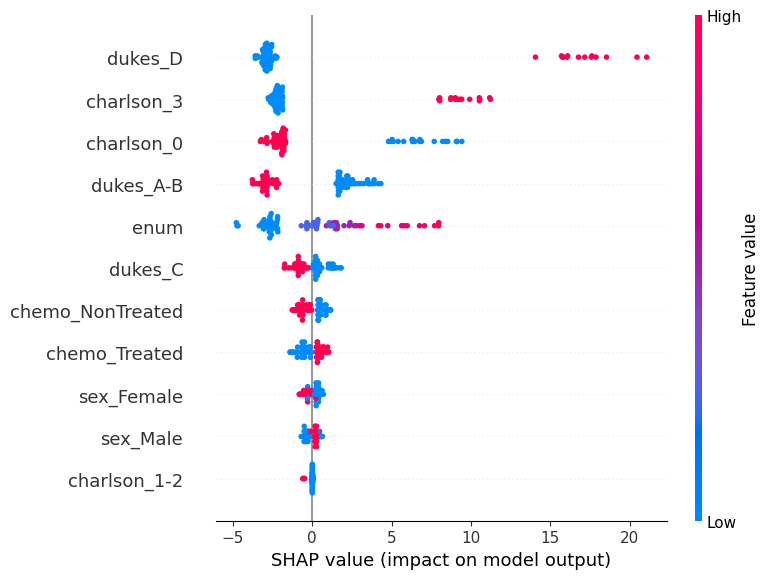

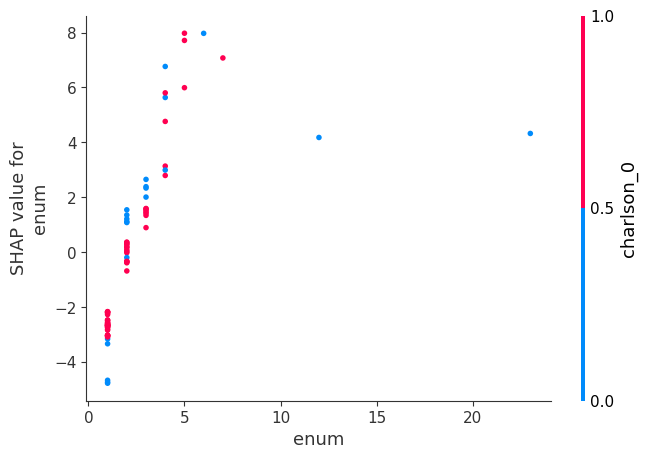

AttributeError: 'RandomSurvivalForest' object has no attribute 'predict_proba'

In [41]:
# model_RSF.get_interpretability_methods(X_train, X_test, y_train, y_test, feature = 'enum', index = 10, plot = True)

### **Permutation Importance**

In [15]:
model_RSF.get_pi_values(X_test, y_test, y_train)

{'charlson_1-2': 0.11490758923565009,
 'dukes_A-B': 0.9618069134348286,
 'dukes_C': 1.2136932896498391,
 'sex_Male': 2.1278902728116176,
 'chemo_NonTreated': 2.163175768037336,
 'sex_Female': 2.1981427693350195,
 'chemo_Treated': 2.3324734351671164,
 'charlson_0': 9.081645687774715,
 'charlson_3': 13.054925735014015,
 'dukes_D': 31.34693523324743,
 'enum': 35.40440330629243}

Displays of variable's importance

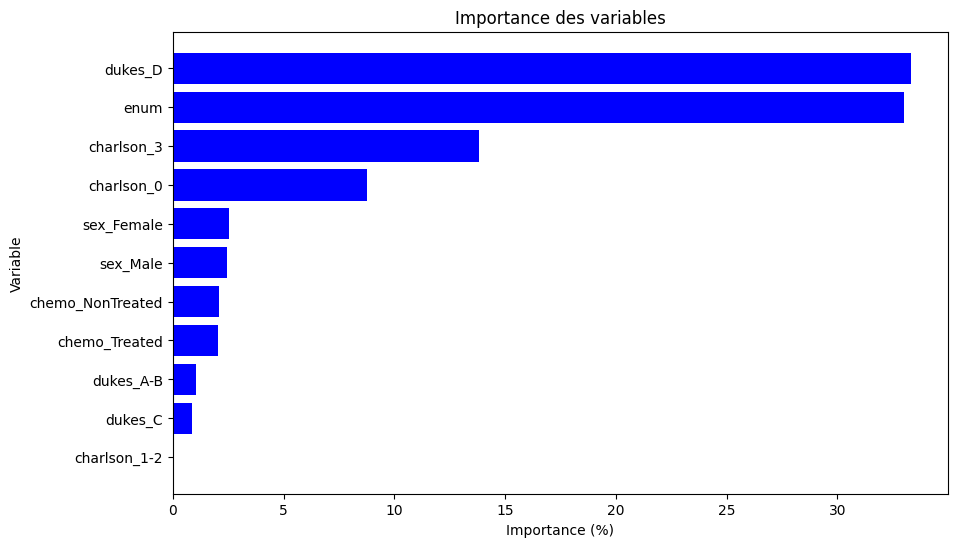

{'charlson_1-2': 0.037900233050095496,
 'dukes_C': 0.855004280250087,
 'dukes_A-B': 1.0343549987429805,
 'chemo_Treated': 2.038094716887442,
 'chemo_NonTreated': 2.0988828502253396,
 'sex_Male': 2.4435137588545226,
 'sex_Female': 2.542413435668696,
 'charlson_0': 8.775775383849577,
 'charlson_3': 13.821955586693155,
 'enum': 33.030331024115405,
 'dukes_D': 33.321773731662695}

In [16]:
model_RSF.get_pi_values(X_test, y_test, y_train, plot = True)

### **SHAP**

For Shap, you can specify whether you want the summary plot with the option (plot=True), but you can also plot the graph representing SHAP values as a function of the values of a specified feature (feature=...).

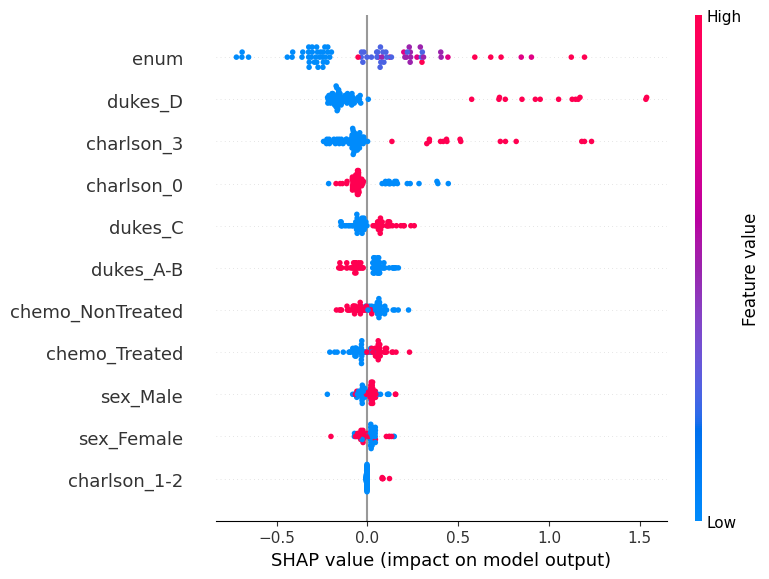

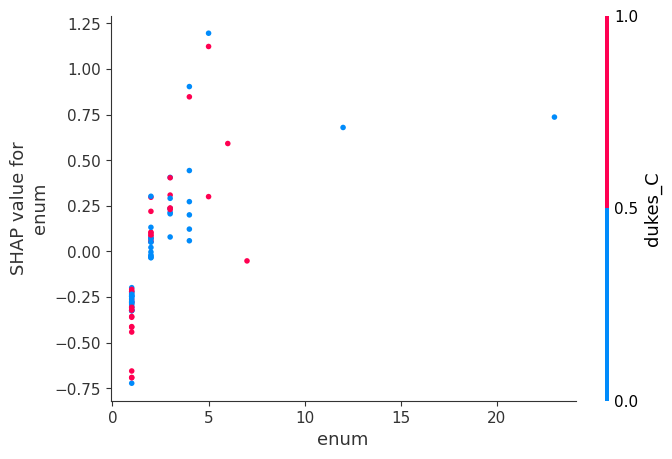

array([[ 7.51099356e-02,  6.20693955e-02,  1.19216088e-03,
        -6.39230881e-03,  6.62152947e-02, -3.05368699e-02,
         7.24491648e-01,  3.83015062e-01, -3.16554813e-03,
         5.10314482e-01,  4.06091604e-01],
       [-1.06152838e-01, -9.52846144e-02,  4.20457135e-02,
         4.38158459e-02,  5.62779258e-02,  7.26752060e-02,
        -1.12502272e-01, -8.39065483e-02, -3.71698355e-03,
        -2.09355431e-01,  2.36218871e-01],
       [-7.21663647e-02, -6.02568494e-02, -3.55856462e-02,
        -4.55594289e-02,  3.44831984e-02,  4.09215496e-02,
        -2.01770200e-01, -3.19766183e-02, -6.44273926e-03,
        -8.44359111e-02, -2.63467879e-01],
       [-1.00246952e-02,  1.74374983e-02,  1.33434354e-01,
         1.18242542e-01,  5.15127033e-02, -5.62801155e-02,
         1.17157000e+00, -1.38186530e-01, -3.66307630e-03,
        -5.61291256e-02, -2.53827580e-02],
       [ 1.50789864e-01,  1.40821364e-01,  2.40321257e-02,
         2.63758494e-02,  1.48157225e-01,  2.03197241e-01,
  

In [17]:
model_RSF.get_shap_values(X_train, X_test, feature = 'enum',  plot=True,)

### **LIME**

We use here the librairie survlimepy in order to generate LIME interpretation of survival models.

In [18]:
model_RSF.get_lime_explanation(X_train, X_test, y_test, sample_idx = [118,345,500])

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but FastKernelSurvivalSVM was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys a

Sample  :  118
Time   :  616.0
Event   : False


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but FastKernelSurvivalSVM was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys a

Sample  :  345
Time   :  2282.0
Event   : False


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but FastKernelSurvivalSVM was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys a

Sample  :  500
Time   :  55.0
Event   : False


## **Hyperparameters importance**

In [21]:
%run Model_survival.ipynb

In [7]:
model = Model(GradientBoostingSurvivalAnalysis())
model.fit(X_train, y_train)

In [8]:
#The hyperparameters_range should contains only a list afo min_val or max_val, except for str hyperparameters (list of str you want to test)

hyperparameters_range = {
    'learning_rate' : [0.001,0.5],
    'n_estimators' : [50,200],
    'max_depth' : [2,13],
    'subsample' : [0.01,1],
    'min_samples_split' : [3,14],
    'min_samples_leaf' : [3,13]
}

Progress of Hyperparameters importance:   0%|          | 0/1400 [00:00<?, ?it/s]

Hyperparameters : learning_rate


Progress of Hyperparameters importance:  14%|█▍        | 200/1400 [01:40<09:15,  2.16it/s]

Hyperparameters : n_estimators


Progress of Hyperparameters importance:  30%|███       | 420/1400 [04:24<18:41,  1.14s/it]

Hyperparameters : max_depth


Progress of Hyperparameters importance:  47%|████▋     | 660/1400 [07:09<05:37,  2.20it/s]

Hyperparameters : subsample


Progress of Hyperparameters importance:  61%|██████▏   | 860/1400 [09:26<05:27,  1.65it/s]

Hyperparameters : min_samples_split


Progress of Hyperparameters importance:  79%|███████▊  | 1100/1400 [12:39<02:59,  1.67it/s]

Hyperparameters : min_samples_leaf


Progress of Hyperparameters importance:  94%|█████████▍| 1320/1400 [15:05<00:54,  1.46it/s]


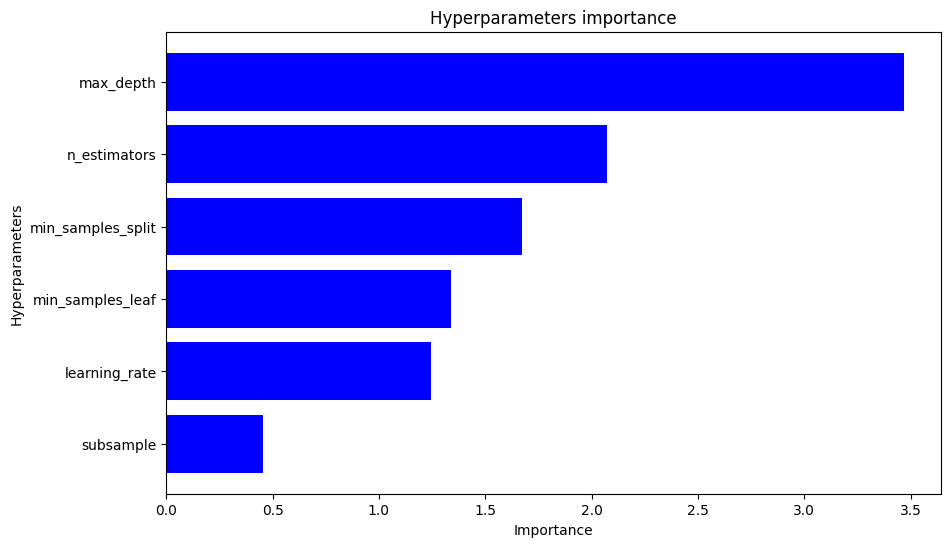

{'subsample': 0.4546646539364979,
 'learning_rate': 1.2449615948140227,
 'min_samples_leaf': 1.3394803346475064,
 'min_samples_split': 1.6747201588730285,
 'n_estimators': 2.0710240589654774,
 'max_depth': 3.4708550715786206}

In [10]:
model.hyperparameters_importances(hyperparameters_range, X_train, y_train, n_trials = 20, n_samples = 10, plot = True)